In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sat Jan 13 22:31:06 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    15W / 230W |  17558MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 35%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-10/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 49948
-rw-rw-r-- 1 scpark scpark   574250  1월 13 22:31 events.out.tfevents.1705152170.GPUSVR01
-rw-rw-r-- 1 scpark scpark 25283605  1월 13 22:29 save_10000
-rw-rw-r-- 1 scpark scpark 25278037  1월 13 22:22 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


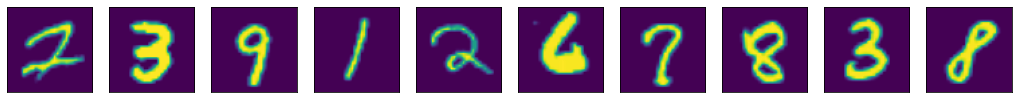

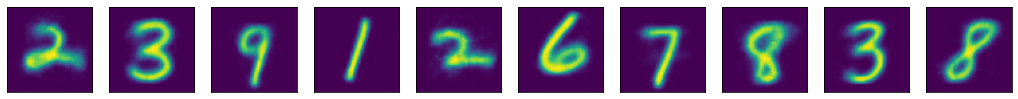

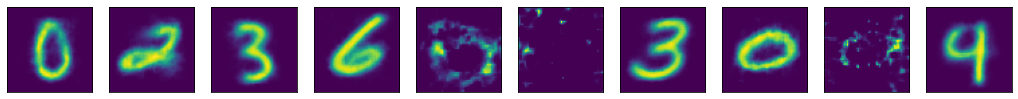

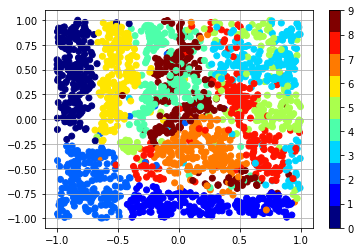

135001
lse_loss 0.0093822767958045
recon_loss 0.09522958844900131
135002
lse_loss 0.011629639193415642
recon_loss 0.09180160611867905
135003
lse_loss 0.010051025077700615
recon_loss 0.08764412254095078
135004
lse_loss 0.011271621100604534
recon_loss 0.08262735605239868
135005
lse_loss 0.012385111302137375
recon_loss 0.08787252753973007
135006
lse_loss 0.010783673264086246
recon_loss 0.09893898665904999
135007
lse_loss 0.010922861285507679
recon_loss 0.0943247526884079
135008
lse_loss 0.012568613514304161
recon_loss 0.08544721454381943
135009
lse_loss 0.010375690646469593
recon_loss 0.08786948770284653
135010
lse_loss 0.01062172930687666
recon_loss 0.08778258413076401
135011
lse_loss 0.009982796385884285
recon_loss 0.08798167109489441
135012
lse_loss 0.011217470280826092
recon_loss 0.08629576861858368
135013
lse_loss 0.012220624834299088
recon_loss 0.08710863441228867
135014
lse_loss 0.009968405589461327
recon_loss 0.08982974290847778
135015
lse_loss 0.009631993249058723
recon_loss 0.09

lse_loss 0.010092876851558685
recon_loss 0.09659355878829956
135124
lse_loss 0.010839185677468777
recon_loss 0.09864166378974915
135125
lse_loss 0.01184801571071148
recon_loss 0.09238351881504059
135126
lse_loss 0.00991553720086813
recon_loss 0.09589549899101257
135127
lse_loss 0.010089673101902008
recon_loss 0.08953347057104111
135128
lse_loss 0.01148787047713995
recon_loss 0.08149167150259018
135129
lse_loss 0.010892616584897041
recon_loss 0.08972033113241196
135130
lse_loss 0.010502545163035393
recon_loss 0.08616116642951965
135131
lse_loss 0.010885736905038357
recon_loss 0.0958908200263977
135132
lse_loss 0.012568052858114243
recon_loss 0.08814649283885956
135133
lse_loss 0.01249631680548191
recon_loss 0.08603720366954803
135134
lse_loss 0.011817028746008873
recon_loss 0.08457043021917343
135135
lse_loss 0.010581953451037407
recon_loss 0.09731950610876083
135136
lse_loss 0.011430338025093079
recon_loss 0.09043604135513306
135137
lse_loss 0.008968780748546124
recon_loss 0.0877220481

135247
lse_loss 0.010593502782285213
recon_loss 0.09358668327331543
135248
lse_loss 0.012147361412644386
recon_loss 0.08610232919454575
135249
lse_loss 0.011472828686237335
recon_loss 0.0879627987742424
135250
lse_loss 0.010199946351349354
recon_loss 0.09398351609706879
135251
lse_loss 0.010085944086313248
recon_loss 0.09746827930212021
135252
lse_loss 0.009615768678486347
recon_loss 0.09838882088661194
135253
lse_loss 0.010227368213236332
recon_loss 0.08655200898647308
135254
lse_loss 0.009578390046954155
recon_loss 0.09337874501943588
135255
lse_loss 0.01112740021198988
recon_loss 0.08135925233364105
135256
lse_loss 0.009293787181377411
recon_loss 0.08432406187057495
135257
lse_loss 0.01188633218407631
recon_loss 0.08786672353744507
135258
lse_loss 0.00970274768769741
recon_loss 0.09057880938053131
135259
lse_loss 0.01164849754422903
recon_loss 0.09162795543670654
135260
lse_loss 0.009682572446763515
recon_loss 0.08678285777568817
135261
lse_loss 0.011475153267383575
recon_loss 0.088

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        